In [2]:
import sys

ENV_COLAB = 'google.colab' in sys.modules
FILE_NAME = 'DATASET_THESIS_2022.csv'

if ENV_COLAB:

  DIR = '/content/drive/My Drive/Thesis Project/'
  from google.colab import output, drive
  !pip install feature_engine hyperopt lightgbm shap optuna

  output.enable_custom_widget_manager()
  drive.mount('/content/drive/')

else:

  DIR = './'

from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score   
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    )

# for feature engineering
from feature_engine import imputation as mdi
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK
from hyperopt import hp
import lightgbm as lgb


df_data = pd.concat([chunk for chunk in tqdm(pd.read_csv(DIR + FILE_NAME, chunksize=1000), desc='Loading data')])
y = df_data.TARGET
X = df_data.drop(columns=['TARGET'])

df_feat =  pd.read_excel(DIR + 'feature_importance_catboost.xlsx')
drop_cols = df_feat[df_feat['PredictionValuesChange'] == 0]['Feature Id'] 
X.drop(columns= drop_cols, inplace= True)

def summary_table(df):

  print(f'Dataset Shape: {df.shape}')
  
  summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
  summary = summary.reset_index()
  summary['Name'] = summary['index']
  summary = summary[['Name', 'dtypes']]
  summary['Missing_Ratio'] = df.isnull().sum().values / len(df)
  summary['Uniques_Num'] = df.nunique().values
  summary['Uniques_Ratio'] = summary['Uniques_Num']/ len(df)
  summary['Mean'] = df.mean().values

  return summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Loading data: 154it [00:26,  5.79it/s]


FileNotFoundError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 42)

pipe = Pipeline([
                ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
                ('scaler', StandardScaler()),
            ])
X_train = pipe.fit_transform(X_train)
X_test =  pipe.transform(X_test)

In [ ]:
def objective_function(params):


    params_dict = {
        'class_weight': 'balanced',  
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'num_leaves': int(params['num_leaves']),
        'boosting_type': params['boosting_type'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
      }

    clf = lgb.LGBMClassifier(**params_dict)

    score = cross_val_score(
        clf, X_train, y_train, 
        cv = StratifiedKFold(n_splits= 5, shuffle =True), scoring ='neg_log_loss', n_jobs= 2
        ).mean()
    
    return {'loss': -score, 'status': STATUS_OK}

# Domain space
space = {
    'learning_rate' : hp.loguniform('learning_rat', np.log(0.1), np.log(1)),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 5, 200, 1),
    'num_leaves': hp.quniform('num_leaves', 5, 25, 1),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.3, 1.0),
    'reg_lambda':hp.uniform('reg_lambda', 0.0, 1.0)
}

# Optimization algorithm
tpe_algorithm = tpe.suggest

# Result history 
trials = Trials()
num_eval = 100

best_params = fmin(
    objective_function, space, tpe.suggest, max_evals = num_eval, 
    trials = trials, rstate = np.random.RandomState(0)
    )


pickle.dump(trials, open(DIR + 'trial_results_v2_1.sav', 'wb'))


In [ ]:
best_params['boosting_type'] = 'gbdt'
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params

{'boosting_type': 'gbdt',
 'colsample_by_tree': 0.6248943139580501,
 'learning_rat': 0.530816574043484,
 'max_depth': 14,
 'n_estimators': 100,
 'num_leaves': 25,
 'reg_lambda': 0.624010054856144}

In [ ]:
params = {
 'class_weight': 'balanced',  
 'boosting_type': 'gbdt',
 'colsample_by_tree': 0.9584435916048172,
 'learning_rat': 0.3,
 'max_depth': 15,
 'n_estimators': 200,
 'num_leaves': 30,
 'reg_lambda': 0.32826016348987364,
 'max_bin' : 255
 }

lgc = lgb.LGBMClassifier(**best_params)

lgc.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose = 10)

X_test_preds = lgc.predict_proba(X_test)
print('AUC: ',roc_auc_score(y_test, X_test_preds[:,1]))
print('accuracy_score: ', accuracy_score(y_test,  lgc.predict(X_test)))





[10]	training's auc: 0.759228	training's binary_logloss: 0.250481	valid_1's auc: 0.73854	valid_1's binary_logloss: 0.254621
[20]	training's auc: 0.779275	training's binary_logloss: 0.241376	valid_1's auc: 0.748739	valid_1's binary_logloss: 0.24923
[30]	training's auc: 0.794707	training's binary_logloss: 0.235336	valid_1's auc: 0.755771	valid_1's binary_logloss: 0.246864
[40]	training's auc: 0.807016	training's binary_logloss: 0.230565	valid_1's auc: 0.760499	valid_1's binary_logloss: 0.245365
[50]	training's auc: 0.817441	training's binary_logloss: 0.226409	valid_1's auc: 0.762639	valid_1's binary_logloss: 0.244702
[60]	training's auc: 0.826628	training's binary_logloss: 0.222796	valid_1's auc: 0.764383	valid_1's binary_logloss: 0.24417
[70]	training's auc: 0.834715	training's binary_logloss: 0.219445	valid_1's auc: 0.766002	valid_1's binary_logloss: 0.243698
[80]	training's auc: 0.842651	training's binary_logloss: 0.216399	valid_1's auc: 0.766112	valid_1's binary_logloss: 0.243626
[90

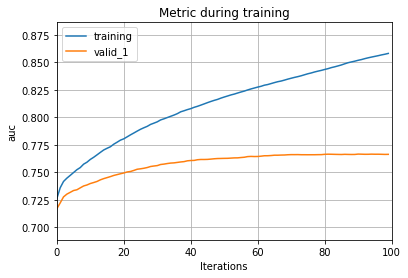

In [ ]:
lgb.plot_metric(lgc, metric ='auc')

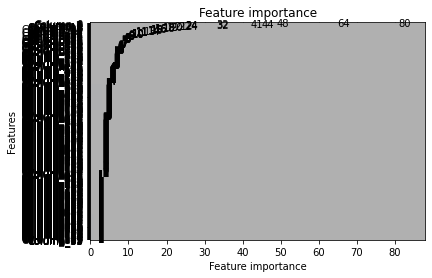

In [ ]:
lgb.plot_importance(lgc)